In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

dialogue_df = pd.read_csv("data/The-Office-Lines-V2.csv", index_col=["season", "episode"])
tokenizer = RegexpTokenizer(r'\w+')
dialogue_df["num_words"] = dialogue_df["line"].apply(lambda x: len(tokenizer.tokenize(x)))

rating_df = pd.read_csv("data/TheOfficeIMDBPerEpisode.csv")
rating_df["episode"] = [x[1] for x in dialogue_df.index.unique()]
rating_df = rating_df[["Season", "episode", "Title", "Rating"]]
rating_df.columns = ["season", "episode", "title", "rating"]
rating_df
rating_df.set_index(["season", "episode"], inplace=True)

rating_df = rating_df.loc[:7]
dialogue_df = dialogue_df.loc[:7]
# sns.regplot(x=np.arange(len(rating_df)), y="rating", data=rating_df)
dialogue_df
# rating_df.loc[rating_df["rating"].argmin()]

title  scene  \
season episode                                        
1      1                               Pilot      1   
       1                               Pilot      1   
       1                               Pilot      1   
       1                               Pilot      1   
       1                               Pilot      1   
...                                      ...    ...   
7      25       Search Committee (Parts 1&2)   6019   
       25       Search Committee (Parts 1&2)   6019   
       25       Search Committee (Parts 1&2)   6019   
       25       Search Committee (Parts 1&2)   6019   
       25       Search Committee (Parts 1&2)   6019   

                                       speaker  \
season episode                                   
1      1                               Michael   
       1                                   Jim   
       1                               Michael   
       1                                   Jim   
       1                               Michael   
...                                        ...   
7      25        Pam as "ninth-biggest client"   
       25       Pam as "fourth-biggest client"   
       25        Pam as "ninth-biggest client"   
       25       Pam as "fourth-biggest client"   
       25                                Creed   

                                                             line  num_words  
season episode                                                                
1      1        All right Jim. Your quarterlies look very good...         14  
       1               Oh, I told you. I couldn't close it. So...         10  
       1        So you've come to the master for guidance? Is ...         16  
       1               Actually, you called me in here, but yeah.          8  
       1          All right. Well, let me show you how it's done.         11  
...                                                           ...        ...  
7      25                                                  Hello!          1  
       25                                        Hi, how are ya?           4  
       25       Ohho! I'm good! Don't you just love paper, and...         14  
       25       Hey, are you single? This seems like a love co...         12  
       25                                            It's Kismet!          3  

[40788 rows x 5 columns]

In [178]:
wrong_names = {"Michael: ":"Michael", "Deangelo":"DeAngelo", "David Wallace": "David", "Daryl":"Darryl", "Dwight: ":"Dwight", "Jim: ":"Jim", "Pam: ":"Pam"}
dialogue_df["speaker"].replace({"Michael: ":"Michael"}, inplace=True)


Michael         10784
Dwight           4791
Jim              4616
Pam              3775
Andy             2010
Kevin            1039
Angela            999
Ryan              989
Oscar             818
Jan               769
Phyllis           722
Kelly             693
Erin              639
Darryl            623
Toby              591
Holly             540
Stanley           492
Meredith          371
David             371
Karen             321
Creed             311
Gabe              296
DeAngelo          246
Charles           221
Roy               207
Jo                189
Donna              81
Carol              79
Katy               78
Danny              68
Josh               56
Helene             47
Todd Packer        38
Todd               38
Hank               36
Mr. Brown          36
Andy:              35
Dwight:            34
Eric               34
Jim:               33
Man                31
Nick               31
Pam:               31
Captain Jack       30
Grotti             30
Tom       

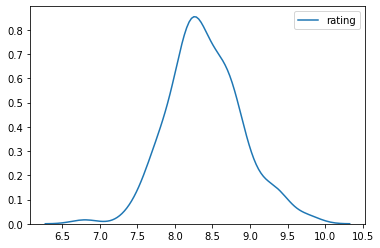

In [114]:
# sns.regplot(x=np.arange(len(rating_df)), y="rating", data=rating_df)
rating_df["rating"].value_counts()
sns.kdeplot(rating_df["rating"])

,character,pearson,p_val,lin_coef
6,Angela,0.192895,0.031143,0.001055
5,Kevin,0.116847,0.183811,0.001023
8,Oscar,0.100748,0.284021,0.000769
3,Pam,0.213773,0.012132,0.000643
9,Jan,0.260732,0.124566,0.000641
1,Dwight,0.176971,0.038568,0.000413
2,Jim,0.152627,0.076080,0.000381
0,Michael,0.250516,0.003384,0.000321
7,Ryan,0.022621,0.812860,0.000089
4,Andy,-0.087146,0.386185,-0.000260


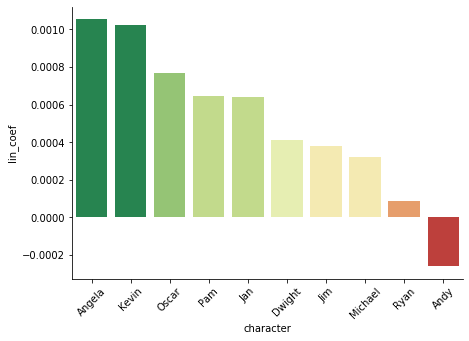

In [142]:
characters = list(dialogue_df["speaker"].value_counts()[:10].index)

combined_df = rating_df.copy()
for character in characters:
    character_text_df = dialogue_df[dialogue_df["speaker"] == character].groupby(["season", "episode"]).sum()["num_words"].to_frame()
    character_text_df.index.name = "id"
    character_text_df.columns = [character]
    combined_df = pd.concat((combined_df, character_text_df), axis=1)
combined_df
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
sns.despine()
plt.xticks(rotation=45)
# ax.set_ylim(-1, 1)

pearson = []
lin_coef = []
p_vals = []
for character in characters:
    y = np.array(combined_df["rating"])
    X = combined_df[character].to_numpy()

    y = y[~np.isnan(X)]
    X = X[~np.isnan(X)]

    # sns.regplot(X, y, scatter=True, ax=ax)
    model = LinearRegression().fit(X.reshape(-1,1), y)
    # plt.scatter(X, y)
    # plt.plot(np.linspace(0,2000,2000), model.predict(np.linspace(0,2000,2000).reshape(-1,1)))
    lin_coef.append(model.coef_[0]) #pearsonr(X,y)[0])
    pearson.append(pearsonr(X,y)[0])
    p_vals.append(pearsonr(X,y)[1])

influence_df = pd.DataFrame({"character": characters, "pearson": pearson, "p_val": p_vals, "lin_coef":lin_coef}).sort_values("lin_coef", ascending=False)

# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

sns.barplot(x=influence_df["character"], y=influence_df["lin_coef"], ax=ax, palette=colors_from_values(influence_df["lin_coef"], "RdYlGn"))
influence_df